This sequence is a good exemple using the loop in and out while using two pulses in the loop in. It first send a trigger to another apparatus (for exemple a microwave sources) and play two pulses, one of the wanted amplitude and a second one of amplitude 0. It can be used to substract a setup background. 
Beacause there is more than one pulses in loop in the dead time management can be a bit more tricky.

This notebook can also be used to understand how to play with the data format when you have interleaved pulses. 

# Import library and stations

In [10]:
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.plotting import plot_dataset,plot_by_id
from qcodes.logger.logger import start_all_logging
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm 
from qcodes.loops import Loop
from matplotlib import cm
from cycler import cycler
from pprint import pprint
from time import sleep

import matplotlib.pyplot as plt
import plotly.express as px
import pickle as pk
import qcodes as qc
import pandas as pd
import numpy as np
import datetime
import warnings
import time
import json
import sys
import os

In [20]:
# path to the RFSoC driver 
sys.path.append(r'C:\Users\nicolas.roch\measurement\Experiment\Drivers')

from RFSoC import RFSoC
try:
    rfsoc = RFSoC('RFSoC', 'TCPIP::{}::{}::SOCKET'.format('192.168.0.11',5001))
except KeyError as er:
    rfsoc.close_all()
    rfsoc = RFSoC('RFSoC', 'TCPIP::{}::{}::SOCKET'.format('192.168.0.11',5001))

    
# to be launched once after a rfsoc reboot  
rfsoc.reset_PLL()

# whether you want to print or not information for rfsoc debugging
rfsoc.debug_mode = False
# visual representation of the sequence played / Not suitable for very long sequence 
# (i.e. more than few hundred of pulses) 
rfsoc.display_sequence = True  

## Convert Volt in dBm an vice-versa

In [21]:
def powtov(power) :
    poww = 10**(power/10)/1000
    v = np.sqrt(50*poww*2)
    return v
def vtopow(v) :
    poww = v**2/(100)
    power = 10*np.log10(poww)+30
    return power

# Rfsoc initialisation

## Pulses parameters

### Channels 

In [22]:
channel_ro = 1 
channel_demod = [1]

###  Pulses parameters

In [23]:
#rfsoc dac parameters
amp_sig = 0.9 # signal amplitude peak-to-peaks in Volt 
freq_sig = 100 # MHz
dc_off = 0 # DC shift in Volt 
phase_sig = 0  # degree 


# ADC
param_sin_1 = {'amp':1,
               'freq':freq_sig,
               'dc_offset':dc_off,
               'phase_offset':phase_sig*np.pi/180}


# DAC
param_sin_I_on = {'amp':amp_sig,
               'freq':freq_sig,
               'dc_offset':dc_off,
               'phase_offset':(phase_sig)*np.pi/180}

param_sin_I_off = {'amp':0,
               'freq':freq_sig,
               'dc_offset':dc_off,
               'phase_offset':(phase_sig)*np.pi/180}

### Time vectors in µs

In [24]:
time_start_trigger = rfsoc.time_conversion(0) #µs
trigger_length     = rfsoc.time_conversion(1) 
wait_after_trig    = rfsoc.time_conversion(10)
#generation
time_start_dac     = wait_after_trig + trigger_length
#acquisition
time_shift         = rfsoc.time_conversion(0.5)
time_start_adc     = time_start_dac + time_shift
acq_length         = rfsoc.time_conversion(10)
dead_time          = rfsoc.time_conversion(4) # deadtime at the end of loop in 

#number of averages
average = 5

### Pulses sequence creation

In [16]:
pulse_sin_I_on = dict(label='ON', 
                      module='DAC', 
                      channel=channel_ro, 
                      mode='sin', 
                      start=time_start_dac, 
                      length=acq_length+2*time_shift,
                      dead_time = acq_length +2*time_shift+2*dead_time,
                      repetitions=average,
                      param=param_sin_I_on, 
                      LUT=True,
                      starting_pointer=0,
                      parent=None)

pulse_sin_I_off = dict(label='OFF', 
                      module='DAC', 
                      channel=channel_ro, 
                      mode='sin', 
                      start=pulse_sin_I_on['start'] + pulse_sin_I_on['length']+dead_time, 
                      length=acq_length+2*time_shift,
                      dead_time = dead_time,
                      repetitions=average,
                      param=param_sin_I_off, 
                      LUT=True,
                      starting_pointer=0,
                      parent=None)


record_sin_on = dict(label='record_ON', 
                      module='ADC', 
                      channel=channel_ro,
                      LUT = True,
                      mode='sin',
                      demodulation_channels=channel_demod,
                      start=time_start_adc, 
                      length=acq_length, 
                      dead_time = pulse_sin_I_on['length']+2*(dead_time)+2*time_shift,
                      repetitions=average,
                      param=[param_sin_1], 
                      parent=None)

record_sin_off = dict(label='record_OFF', 
                      module='ADC', 
                      channel=channel_ro,
                      LUT = True,
                      mode='sin',
                      demodulation_channels=channel_demod,
                      start=pulse_sin_I_on['start'] + pulse_sin_I_on['length'] + dead_time + time_shift, 
                      length=acq_length, 
                      dead_time = dead_time,
                      repetitions=average,
                      param=[param_sin_1], 
                      parent=None)

trigger_pulse = dict(label='trigger', 
                     module='DAC', 
                     channel=channel_ro, 
                     mode='trigger', 
                     start =time_start_trigger, 
                     length=trigger_length, 
                     repetitions=1,
                     LUT=True,
                     starting_pointer=0,
                     param=None,
                     parent=None)
                     
pulses = pd.DataFrame()
pulses = pd.concat([pulses, pd.DataFrame.from_records([trigger_pulse])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([pulse_sin_I_on])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([pulse_sin_I_off])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([record_sin_on])], ignore_index=True)
pulses = pd.concat([pulses, pd.DataFrame.from_records([record_sin_off])], ignore_index=True)

rfsoc.pulses = pulses

## Rfsoc setting, memory filling and sequencing

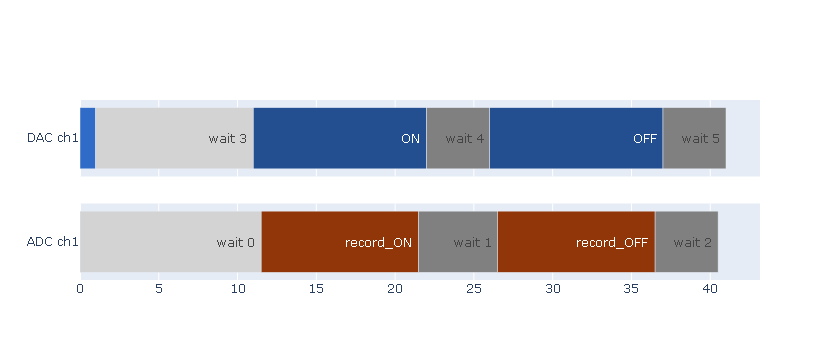

"\nNote that when using 'repetitions' the all sequence is not displayed, only the two first ones are shown. \nThe dark color indicate this repetition.  \n\n"

In [17]:
n_points = 100 # number of time the displayed sequence is played (loop out in the doc) 

rfsoc.acquisition_mode('INT')
rfsoc.n_points(n_points)
rfsoc.process_sequencing_IQ_table()


"""
Note that when using 'repetitions' the all sequence is not displayed, only the two first ones are shown. 
The dark color indicate this repetition.  

"""

In [18]:
res =  rfsoc.IQINT_ALL.get()

IntProgress(value=0, max=1000)

Data curruption: rfSoC did not send all data points(0/1000).
Data curruption: rfSoC did not send all data points(0/1000).
Data curruption: rfSoC did not send all data points(0/1000).
Data curruption: rfSoC did not send all data points(0/1000).


KeyboardInterrupt: 

In [ ]:
I_no_avg = res[0][0].reshape(rfsoc.n_points(), 2*average)[:,2:] #we trash the first average point 
Q_no_avg = res[1][0].reshape(rfsoc.n_points(), 2*average)[:,2:] #we trash the first average point 

I_no_avg_on  = I_no_avg[:,::2]
I_no_avg_off = I_no_avg[:,1::2]

Q_no_avg_on  = Q_no_avg[:,::2]
Q_no_avg_off = Q_no_avg[:,1::2]

amp_no_avg_off = 2*np.sqrt(I_no_avg_off**2+Q_no_avg_off**2)/param_sin_1['amp']
amp_no_avg_on = 2*np.sqrt(I_no_avg_on**2+Q_no_avg_on**2)/param_sin_1['amp']

ph_no_avg_off = np.arctan(Q_no_avg_off/I_no_avg_off)  
ph_no_avg_off_unwrap = np.unwrap(2*ph_no_avg_off, axis=0)/2

ph_no_avg_on = np.arctan(Q_no_avg_on/I_no_avg_on)  
ph_no_avg_on_unwrap = np.unwrap(2*ph_no_avg_on, axis=0)/2


V_out_on = np.average(amp_no_avg_on, axis=1)
V_out_off = np.average(amp_no_avg_off, axis=1)

phi_on = np.average(ph_no_avg_on_unwrap,axis=1)
phi_off = np.average(ph_no_avg_off_unwrap,axis=1)

# P_out_off = vtopow(np.average(amp_no_avg_off, axis=1))


fig, ax = plt.subplots(1, 2,sharex=True, figsize=(10,4))

ax[0].ticklabel_format(useOffset=False)

ax[0].set_xlabel(r'Sample')
ax[0].set_ylabel(r'$V$ [mV]')
ax[1].set_ylabel(r'$\theta$ [rad]')

ax[0].plot(V_out_on*1.e3,'-',lw=1.25,label='on')
ax[0].plot(V_out_off*1.e3,'-',lw=1.25,label='off')

ax[1].plot(phi_on,'-',lw=1.25,label='on')
ax[1].plot(phi_off,'-',lw=1.25,label='off')

ax[0].legend(loc='best')
fig.tight_layout()